In [1]:
import wfdb
from wfdb import processing
import scipy
from scipy import signal
import scipy.interpolate
from scipy.interpolate import interp1d
import statistics
from statistics import mode
import random
import pickle
import ast
import numpy as np
import tqdm
from tqdm import tqdm
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import pywt
from progressbar import AnimatedMarker, Bar, BouncingBar, Counter, ETA, \
    AdaptiveETA, FileTransferSpeed, FormatLabel, Percentage, \
    ProgressBar, ReverseBar, RotatingMarker, \
    SimpleProgress, Timer, UnknownLength




In [2]:
# A function to load the raw data using wfdb
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_lr)]
    else:
        data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_hr)]
    data = np.array([signal for signal, meta in data])
    return data

In [3]:
path = 'Data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
sampling_rate=100

# Here Y is the full database for each patient including height, weight etc
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: eval(x))
# Load raw signal data (12 lead)
X = load_raw_data(Y, sampling_rate, path)

print('data shape:', X.shape)


100%|██████████| 21837/21837 [01:42<00:00, 212.20it/s]


data shape: (21837, 1000, 12)


In [4]:
# Random plotting function
random.seed(1)
def plot(X, Y, i, rand, info): 
    if rand==True:
        int=random.randrange(len(X))
    else:
        int=i
    if info==True:
        print(Y.iloc[int])
    print(int)
    plt.plot(X[int,:300, 1])
    plt.grid()
    plt.xlabel('samples')
    plt.ylabel('mV/Lead 1')
    plt.show()

In [5]:
# Fnction to remove baseline wander 
def isoelectric_removal(X):
    fit=np.polyfit(np.linspace(0, len(X), len(X)), X, 8)
    vals=np.polyval(fit, np.linspace(0, len(X), len(X)))
    return X-vals

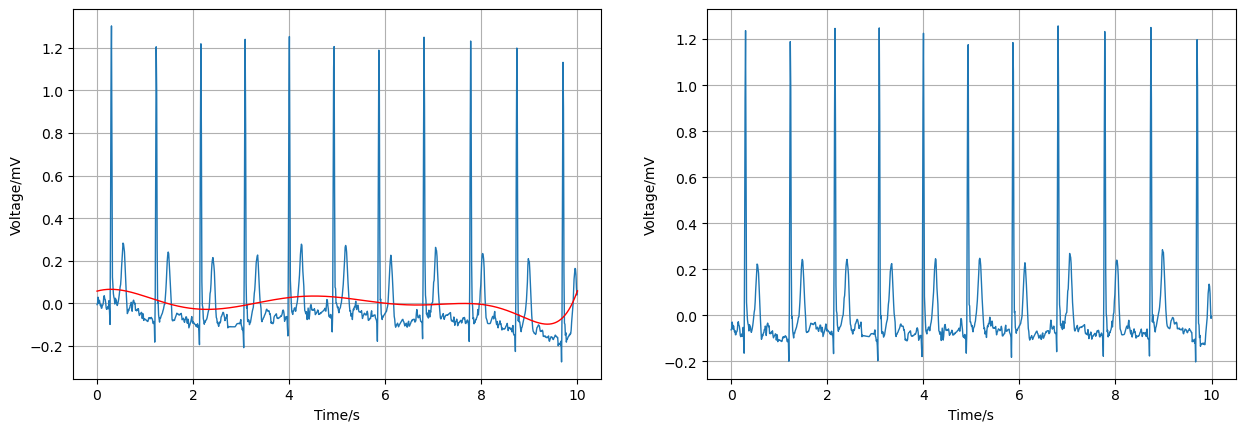

In [6]:
# Lets plot an ECG example with/without isoelectric line

ex=X[50,:,1]
fit=np.polyfit(np.linspace(0, len(ex), len(ex)), ex, 8)
vals=np.polyval(fit, np.linspace(0, len(ex), len(ex)))
iso=ex-vals
time=np.linspace(0,10,1000)
fig, axs = plt.subplots(1,2)
fig.set_figwidth(15)
axs[0].plot(time, ex, lw=1)
axs[0].plot(time, vals, color='r', lw=1)
axs[0].set_ylabel('Voltage/mV')
axs[0].set_xlabel('Time/s')
axs[0].grid()

axs[1].plot(time, iso, lw=1)
axs[1].grid()
axs[1].set_ylabel('Voltage/mV')
axs[1].set_xlabel('Time/s')
plt.show(fig)

In [7]:
# Find nans
nans=[]
for i in range(len(X)):
    if i%5000==0:
        print(i)
    for p in range(12):
        if np.isnan(X[i,:,p]).any():
            print('nan', i)
            nans.append(i)

0
5000
10000
15000
20000


In [8]:
# Delete patients with nans
X_nan=np.delete(X,nans,0)
Y_nan=Y.drop(nans, 0)
print(X_nan.shape, Y_nan.shape)

(21837, 1000, 12) (21837, 27)


<ipython-input-8-99ca3ae28969>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  Y_nan=Y.drop(nans, 0)


In [9]:
# Isoelectric removal of each ECG
X_iso=X_nan
for i in range(len(X_iso)):
    for p in range(12):
        X_iso[i,:,p]=isoelectric_removal(X_iso[i,:,p])
    if i%5000==0:
        print(i)

0
5000
10000
15000
20000


In [10]:
# Function to find the peaks of an ECG

def peakfinder(X, no_leads):
    
    locations=[]
    n_peaks=[]
#   Cycles through each lead

    for i in range(no_leads):
        lead=X[:,i]
        s=pd.Series(lead)
        s=s.rolling(3).var()
        s=s**2
        maxval=s.max()
        locations_temp,_=scipy.signal.find_peaks(s, maxval/100, distance=30)
        n_peaks.append(len(locations_temp))
        
        for counter, value in enumerate(locations_temp):
            if value<10:
                arr=lead[:value]
                locations_temp[counter]=np.argmax(arr)
            else:
                arr=lead[value-5:value+5]
                locations_temp[counter]=value-(5-np.argmax(arr))
            locations_temp=np.array(locations_temp)
        locations.append(locations_temp)
        
    locations_true=[]
    m=mode(n_peaks)
    n_peaks_true=0
    
#     Finds the mode of peak locations for the 12 leads
    for x in range(12):
        if len(locations[x])==m:
            n_peaks_true+=1
            locations_true.append(locations[x])
    array=np.vstack(locations_true)
    final=[]
    for i in range(array.shape[1]):
        final.append(mode(array[:,i]))

    return final

In [11]:
# Find the number of peaks in each ECG
n_peaks=[]
for s in range(len(X_iso)):
    example=X_iso[s,:,:]
    peaks=peakfinder(example, 12) 
    n_peaks.append(len(peaks))
    if s%5000==0:
        print(s)

0
5000
10000
15000
20000


In [12]:
# Remove ECGs for which less than 5 beats were detected - this may indicate faulty data
n_peaks_arr=np.array(n_peaks)
X_filt=X_iso[n_peaks_arr>8]
Y_filt=Y_nan[n_peaks_arr>8]
n_beats_filt=[i-3 for i in n_peaks_arr if i>8]

In [13]:
# Polynomial interpolation to stretch/compress each beat to a set number of data points for imputting into ECG
def time_stretcher(X, size, new_size):
    xloc = np.arange(size)
    new_xloc = np.linspace(0, size, new_size)
    new_data = np.interp(new_xloc, xloc, X)
    return new_data

In [14]:
def normalise(X):
    return (X-min(X))/(max(X)-min(X))

In [15]:
# Splitting into beats 1/3 behind peak to 2/3 ahead
def segmenter(X, locations):

    n_beats=len(locations)-1


#     print(n_beats)
    avg_beat_length=np.sum(np.diff(locations))/n_beats
    bpm=60*100/(avg_beat_length)
    final_beats=[]

    for x in range(n_beats-2):
        
        start=int(locations[x+1]-(avg_beat_length)*1/3)
        end=int(locations[x+1]+(avg_beat_length)*2/3)
        beats=X[start:end]
        beat_dist=end-start

#         Normalise each segment to 200 samples
        beats=normalise(time_stretcher(beats, beat_dist, 200))

#         stack each beat into a single array
        if x==0:
            beat_array=beats
        else:
            beat_array=np.vstack((beat_array, beats))

    return beat_array, beat_dist



In [18]:
print('There are {:d} ECGs and {:d} individual beats'.format(len(n_beats_filt),sum(n_beats_filt)))

There are 21045 ECGs and 200128 individual beats


In [19]:
n_beats=[]
widgets = [Percentage(),
               ' ', Bar(),
               ' ', ETA(),]

# Create an array of zeros of the correct shape and fill it with values - much faster 
X_arr=np.zeros((sum(n_beats_filt), 200, 12))
pbar = ProgressBar(widgets=widgets, maxval=500)
for s in pbar(range(len(n_beats_filt))):  

        
    example=X_filt[s,:,:]
    peaks=peakfinder(example, 12) 

    for i in range(12):
        b_array, beat_dist=segmenter(example[:,i], peaks)
        if i==0:
            total_array=b_array

        elif i==1:

            total_array=np.concatenate((total_array[:,:,None], b_array[:,:,None]), axis=2)
        else:

            total_array=np.concatenate((total_array, b_array[:,:,None]), axis=2)
        
    n=len(total_array)
    
    for x in range(n):
        X_arr[sum(n_beats)+x]=total_array[x]
    n_beats.append(n)


<ipython-input-14-a3e1ae8e2c07>:2: RuntimeWarning: invalid value encountered in true_divide
  return (X-min(X))/(max(X)-min(X))
100% |##########################################################| Time: 0:10:45


In [31]:
# We now duplicate the patient info according to how many beats were obtained from their ECG
Y_arr=Y_filt.loc[Y_filt.index.repeat(n_beats)]

In [235]:
# Sorry, this is gonna be large (15GB)!
X_arr_reshaped = X_arr.reshape(X_arr.shape[0], -1)
np.savetxt('Xdata_all.csv', X_arr_reshaped)

In [ ]:
Y_arr.to_csv('Ydata_all.csv', encoding='utf-8', index=False)